# Dynamic Auditing of Trained NNPs
### Perform NNP-driven relaxation on common set of starting structures generated from MC moves
### Compare against TTM- and MP2-driven relaxations

In [ ]:
import numpy as np
from ase.db import connect
import seaborn as sns
import matplotlib.pyplot as plt
import ase
from ase.geometry.analysis import Analysis
import networkx as nx
import pandas as pd
from operator import itemgetter
from multiprocessing import Pool

def flatten(l):
    return [item for sublist in l for item in sublist]

from utils import audit, graph

#### Load starting structure set and corresponding TTM/MP2 minima
* TODO: load initial MC structures, relaxed with TTM, and relaxed with MP2

In [3]:
with connect('./dbs-before-training/initial-mp2.db') as conn:
    print(f"{conn.count()} items in initial MC structure database")
    clusters = [conn.get_atoms(i+1) for i in range(conn.count())]
    energy = np.array([cluster.get_potential_energy() for cluster in clusters])

1332 items in MP2 database


In [4]:
with connect('./dbs-before-training/min-mp2.db') as conn:
    print(f"{conn.count()} items in MP2 database")
    mp2_clusters = [conn.get_atoms(i+1) for i in range(conn.count())]
    mp2_energy = np.array([cluster.get_potential_energy() for cluster in mp2_clusters])

480 items in MP2 database


In [ ]:
with connect('./dbs-before-training/5000-ttm.db') as con:
    print(f"{conn.count()} items in TTM database")
    ttm_clusters = [conn.get_atoms(i+1) for i in range(conn.count())]
    ttm_energy = np.array([cluster.get_potential_energy() for cluster in ttm_clusters])

#### NNP-driven relxation
* TODO: relax initial MC structures with trained NNP

#### Energetic comparison
* distribution-to-distribution comparison (identify systematic errors)
* pairwise comparison (TODO)

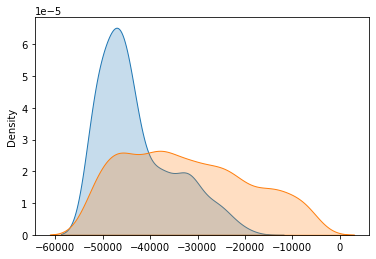

In [27]:
sns.kdeplot(mp2_energy, fill=True)
sns.kdeplot(energy, fill=True)
#sns.kdeplot(ttm_energy)
plt.show()

In [19]:
ks = audit.compute_ks_statistic(energy, mp2_energy)
wdist = audit.compute_wasserstein_distance(energy, mp2_energy)
print(ks, wdist)

0.41846846846846847 10670.52660474275


In [26]:
# TODO: pairwise comparison

#### Structural comparison
* distribution-to-distribution comparison (identify systematic errors)

In [7]:
def get_structure_metrics(cluster):
    """
    Params:
        cluster: ASE Atoms object
    Returns:
        OH covalent bonds (A)
        HOH bond angles (deg)
        OH_hbond_dists (A)
        HOH_hbond_angles (deg)
        OHO_hbond_angles (deg)   # https://pubs.acs.org/doi/10.1021/acs.biochem.8b00217 FIG 9
        OO_hbond_dist (A)        # https://pubs.acs.org/doi/10.1021/acs.biochem.8b00217 FIG 9
    """
    # get covalent bond distances and angles
    ana = Analysis(cluster)
    OH_cov_pairs = ana.get_bonds('O', 'H', unique=True)
    OH_covalent_bonds = ana.get_values(OH_cov_pairs)
    HOH_covalent_angles = ana.get_values(ana.get_angles('H', 'O', 'H', unique=True))
    #ana.clear_cache()
    
    OH_cov_pairs=OH_cov_pairs[0]
    
    # convert to H-bonding graph
    G = graph.create_graph(cluster)

    # filter out O-H covalent bonds
    OH_hbond_pairs = list(set(G.edges)-set(OH_cov_pairs))

    # compute H---O distances
    OH_hbond_dists = [cluster.get_distance(i,j) for i,j in OH_hbond_pairs]

    # get atomic numbers of OH hbond pairs
    OH_hbond_Z = [itemgetter(i,j)(cluster.get_atomic_numbers()) for i,j in OH_hbond_pairs]
    
    O_id = np.where(np.stack(OH_hbond_Z)==8)[1]
    O_nodes = [pair[O_id[i]] for i,pair in enumerate(OH_hbond_pairs)]

    # match those O node indices with their H in OH_conv_pairs to get ther Hs
    HOH_hbond_angles=[]
    for i,O in enumerate(O_nodes):
        bonded_H = list(set(flatten(itemgetter(np.where(np.stack(OH_cov_pairs)==O)[0])(np.stack(OH_cov_pairs)))))
        bonded_H.remove(O)
        angles = []
        for k in bonded_H: 
            
            try:
                # compute H---O-Hs angles for both H
                angles.append(cluster.get_angle(OH_hbond_pairs[i][0],OH_hbond_pairs[i][1],k))
            except:
                pass
        if len(angles)>0:
            # keep angle closest to 180deg
            angles = max([a if a > 90 else 180-a for a in angles])
            HOH_hbond_angles.append(angles)

    H_id = np.where(np.stack(OH_hbond_Z)==1)[1]
    H_nodes = [pair[H_id[i]] for i,pair in enumerate(OH_hbond_pairs)]

    OHO_hbond_angles=[]
    OO_hbond_dist=[]
    for i,H in enumerate(H_nodes):
        bonded_O = list(set(flatten(itemgetter(np.where(np.stack(OH_cov_pairs)==H)[0])(np.stack(OH_cov_pairs)))))
        bonded_O.remove(H)
        try:
            # compute O-H---O angle 
            angle = cluster.get_angle(OH_hbond_pairs[i][0],OH_hbond_pairs[i][1],bonded_O[0]) 
            # convert angle closest to 180deg
            angle = angle if angle > 90 else 180-angle
            OHO_hbond_angles.append(angle)

            Hbonded_O = list(OH_hbond_pairs[i])
            Hbonded_O.remove(H)
            OO_hbond_dist.append(cluster.get_distance(Hbonded_O[0],bonded_O[0]))
        except:
            pass
    
    labels = ['OH_cov', 'HOH_cov', 'OH_hbond', 'HOH_hbond', 'OHO_hbond', 'OO_hbond']
    values = [OH_covalent_bonds[0], HOH_covalent_angles[0], OH_hbond_dists, HOH_hbond_angles, OHO_hbond_angles, OO_hbond_dist]
    
    type_list=[]
    value_list=[]
    for i in range(len(labels)):
        value_list.append(values[i])
        type_list.append([labels[i]]*len(values[i]))
        
    # return df
    return pd.DataFrame({'type':flatten(type_list), 'value':flatten(value_list)})
    
    # return separate
    #return OH_covalent_bonds[0], HOH_covalent_angles[0], OH_hbond_dists, HOH_hbond_angles, OHO_hbond_angles, OO_hbond_dist

In [10]:
with Pool(10) as p:
    d = p.map(get_structure_metrics, mp2_clusters)
    
df_a = pd.concat(d, sort=False, ignore_index=True)
df_a['method'] = 'mp2'

In [11]:
with Pool(10) as p:
    d = p.map(get_structure_metrics, clusters)
    
df_b = pd.concat(d, sort=False, ignore_index=True)
df_b['method'] = 'initial'

In [12]:
# join dataframes for easy plotting
df=pd.concat([df_a,df_b], sort=False, ignore_index=True)
df.head()

,type,value,method
0,OH_cov,0.952979,mp2
1,OH_cov,0.974932,mp2
2,OH_cov,0.954767,mp2
3,OH_cov,0.968687,mp2
4,OH_cov,0.970109,mp2


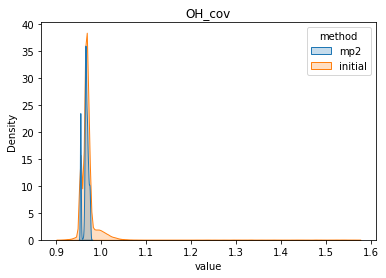

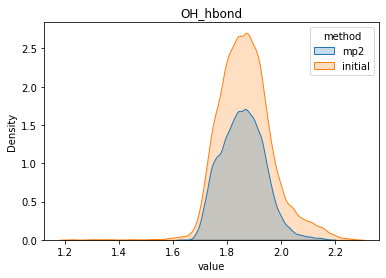

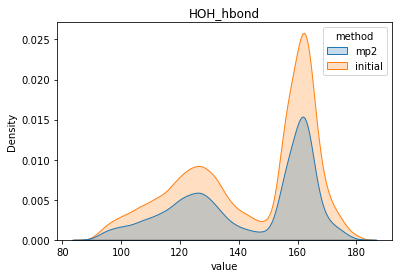

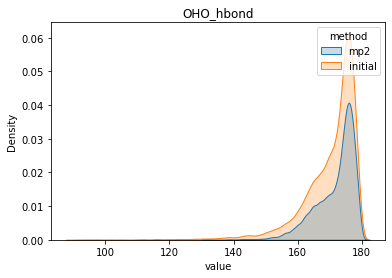

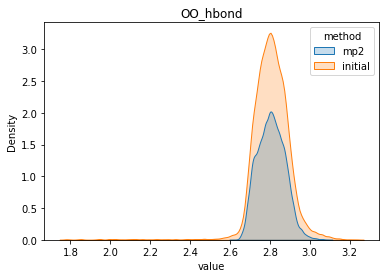

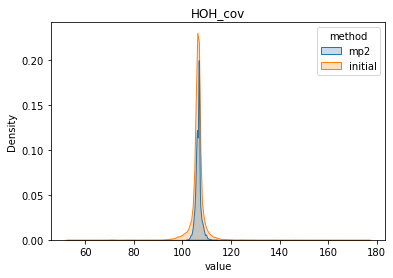

In [28]:
for t in df['type'].value_counts().index:
    sns.kdeplot(data=df.loc[df['type']==t], x='value', hue='method', common_norm=True, fill=True, bw_adjust=0.75)
    plt.title(t)
    plt.show()

In [17]:
for t in df['type'].value_counts().index:
    a = df.loc[(df['type']==t)&(df['method']=='initial')]['value'].tolist()
    b = df.loc[(df['type']==t)&(df['method']=='mp2')]['value'].tolist()
    ks = audit.compute_ks_statistic(a, b)
    wdist = audit.compute_wasserstein_distance(a, b)
    print(t, ks, wdist)

OH_cov 0.12520777667353955 0.006054760813942477
OH_hbond 0.05860076784626422 0.01466687836185565
HOH_hbond 0.03066221412245207 0.906764095587848
OHO_hbond 0.06355831902753029 1.7759968586316845
OO_hbond 0.03078324861560444 0.010868623071365938
HOH_cov 0.08556521482554012 0.9241565630856983


#### Graph structure comparison
* pairwise comparison (TODO)

In [21]:
cluster = mp2_clusters[1]

In [22]:
G = graph.create_graph(cluster)

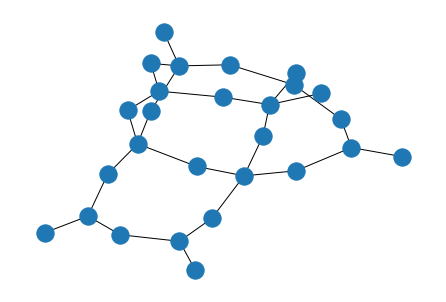

In [23]:
nx.draw_spring(G)

In [24]:
C = graph.coarsen_graph(G)
C

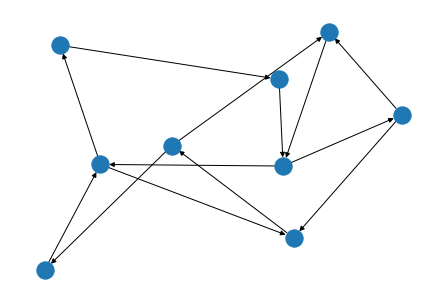

In [25]:
nx.draw_spring(C)

In [ ]:
# TODO: 1-to-1 comparison between pairs of graphs